## Load Libraries

In [0]:
!pip install pycaret[full]
!pip install -U threadpoolctl

  Obtaining dependency information for pycaret[full] from https://files.pythonhosted.org/packages/3e/6f/b3d59fac3869a7685e68aecdd35c336800bce8c8d3b45687bb82cf9a2848/pycaret-3.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm>=4.62.0 from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.1 MB/s eta 0:00:00
  Obtaining dependency information for jinja2>=3 from https://files.pythonhosted.org/packages/62/a1/3d680cbfd5f4b8f15abc1d571870c5fc3e594bb582bc3b64ea099db13e56/jinja2-3.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>1.4.0 from https://files.pythonhosted.org/packages/c6/38/48b75c3d8d268a3f19837cb8a89155ead6e97c6892bb64837183ea41db2b/scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_

In [0]:
dbutils.library.restartPython()

In [0]:
import warnings
import shap
import numpy as np
warnings.filterwarnings('ignore')

## Load dataset and create experiment

In [0]:
ml_df_class = spark.table('hive_metastore.default.hse_cc_pred_ml').toPandas().drop(columns=['number_of_near_miss_incidents'])
ml_df_class['random_feature'] = np.random.rand(len(ml_df_class))

In [0]:
from pycaret.classification import *

s = setup(
    ml_df_class, 
    target="is_near_miss", 
    # ignore_features = ['production_date'],
    fix_imbalance=True, 
    normalize=True, 
    transformation=True,
    memory=False,
    session_id=8933
)

,Description,Value
0,Session id,8933
1,Target,is_near_miss
2,Target type,Binary
3,Original data shape,"(2192, 28)"
4,Transformed data shape,"(3666, 37)"
5,Transformed train set shape,"(3008, 37)"
6,Transformed test set shape,"(658, 37)"
7,Numeric features,24
8,Categorical features,3
9,Preprocess,True


In [0]:
X_train, X_test, y_train, y_test = get_config('X_train'), get_config('X_test'), get_config('y_train'), get_config('y_test')
X_train['is_near_miss'] = y_train
X_test['is_near_miss'] = y_test
X_train_spark = spark.createDataFrame(X_train)
X_test_spark = spark.createDataFrame(X_test)

X_train_spark.write.format('delta').mode('overwrite').option('overwriteSchema', 'true').saveAsTable('hive_metastore.default.hse_cc_pred_ml_train')
X_test_spark.write.format('delta').mode('overwrite').option('overwriteSchema', 'true').saveAsTable('hive_metastore.default.hse_cc_pred_ml_test')

## Fit Models

In [0]:
best = compare_models(sort='F1', exclude=['lightgbm'], n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9472,0.7048,0.4000,0.1673,0.2331,0.2111,0.2340,0.055
nb,Naive Bayes,0.8865,0.8864,0.8333,0.1296,0.2234,0.1963,0.3004,0.051
qda,Quadratic Discriminant Analysis,0.9674,0.8643,0.2667,0.1919,0.2137,0.2009,0.2078,0.052
rf,Random Forest Classifier,0.9804,0.8357,0.0333,0.1000,0.0500,0.0485,0.0562,0.127
ada,Ada Boost Classifier,0.9778,0.8186,0.0333,0.1000,0.0500,0.0450,0.0523,0.112
gbc,Gradient Boosting Classifier,0.9804,0.7596,0.0333,0.1000,0.0500,0.0485,0.0562,0.295
et,Extra Trees Classifier,0.9804,0.8385,0.0333,0.1000,0.0500,0.0485,0.0562,0.098
xgboost,Extreme Gradient Boosting,0.9804,0.8398,0.0333,0.1000,0.0500,0.0485,0.0562,0.072
catboost,CatBoost Classifier,0.9804,0.8423,0.0333,0.1000,0.0500,0.0485,0.0562,4.452
ridge,Ridge Classifier,0.9329,0.8488,0.0667,0.0225,0.0336,0.0071,0.0086,0.051


Processing:  94%|█████████▍| 63/67 [01:06<00:09,  2.46s/it]WARNING:matplotlib.font_manager:findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Processing:  97%|█████████▋| 65/67 [01:18<00:06,  3.47s/it]WARNING:matplotlib.font_manager:findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Processing:  99%|█████████▊| 66/67 [01:30<00:05,  5.05s/it]WARNING:matplotlib.font_manager:findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

In [0]:
best_ensemble = stack_models(best, choose_better=True, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9675,0.8035,0.3333,0.2500,0.2857,0.2694,0.2724
1,0.9870,0.9625,0.3333,1.0000,0.5000,0.4951,0.5736
2,0.9740,0.9823,0.6667,0.4000,0.5000,0.4875,0.5044
3,0.9805,0.9702,0.6667,0.5000,0.5714,0.5617,0.5678
4,0.9477,0.9400,0.0000,0.0000,0.0000,-0.0251,-0.0260
5,0.9804,0.9467,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9608,0.9222,0.0000,0.0000,0.0000,-0.0200,-0.0200
7,0.9412,0.7178,0.0000,0.0000,0.0000,-0.0268,-0.0286
8,0.9542,0.9556,0.3333,0.1667,0.2222,0.2013,0.2143


Processing:  83%|████████▎ | 5/6 [00:00<00:00,  5.42it/s]WARNING:matplotlib.font_manager:findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Original model was better than the stacked model, hence it will be returned. NOTE: The display metrics are for the stacked model (not the original one).


In [0]:
best_ensemble_tuned = tune_model(best_ensemble, choose_better=True, optimize='F1', search_library='optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9351,0.8135,0.6667,0.1818,0.2857,0.2632,0.3258
1,0.9156,0.7870,0.6667,0.1429,0.2353,0.2099,0.2823
2,0.9351,0.9669,0.6667,0.1818,0.2857,0.2632,0.3258
3,0.9675,0.9581,0.6667,0.3333,0.4444,0.4296,0.4572
4,0.9346,0.9533,1.0000,0.2308,0.3750,0.3544,0.4641
5,0.9346,0.9311,0.6667,0.1818,0.2857,0.2630,0.3256
6,0.9281,0.9467,0.6667,0.1667,0.2667,0.2429,0.3094
7,0.9150,0.5867,0.0000,0.0000,0.0000,-0.0311,-0.0374
8,0.9412,0.9478,0.6667,0.2000,0.3077,0.2862,0.3441


Processing:   0%|          | 0/7 [00:00<?, ?it/s]INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1534 samples...


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!
Processing:  86%|████████▌ | 6/7 [00:37<00:05,  5.15s/it]WARNING:matplotlib.font_manager:findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

''

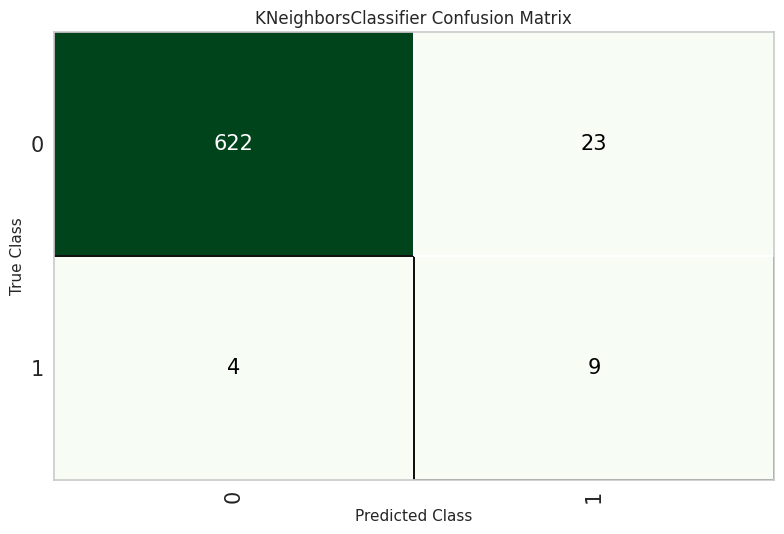

In [0]:
plot_model(best_ensemble_tuned, plot='confusion_matrix')

''

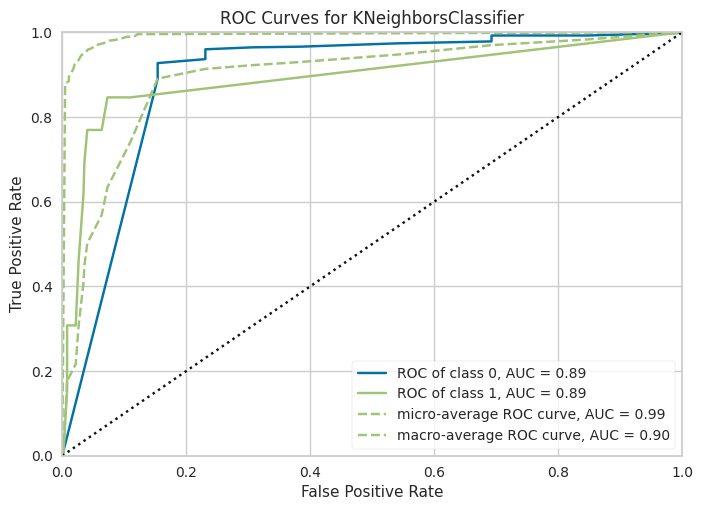

In [0]:
plot_model(best_ensemble_tuned, plot='auc')

''

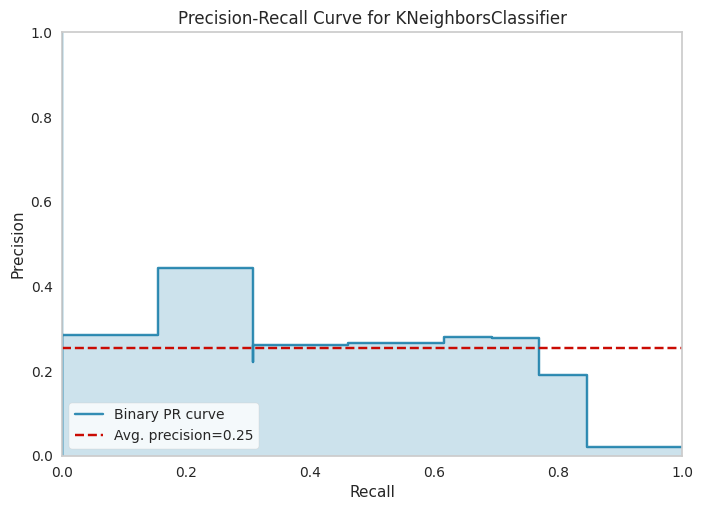

In [0]:
plot_model(best_ensemble_tuned, plot='pr')

''

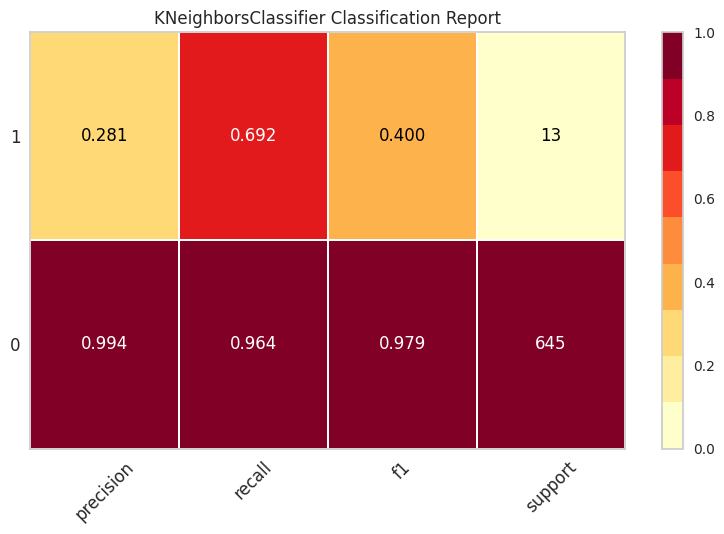

In [0]:
plot_model(best_ensemble_tuned, plot='class_report')

''

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

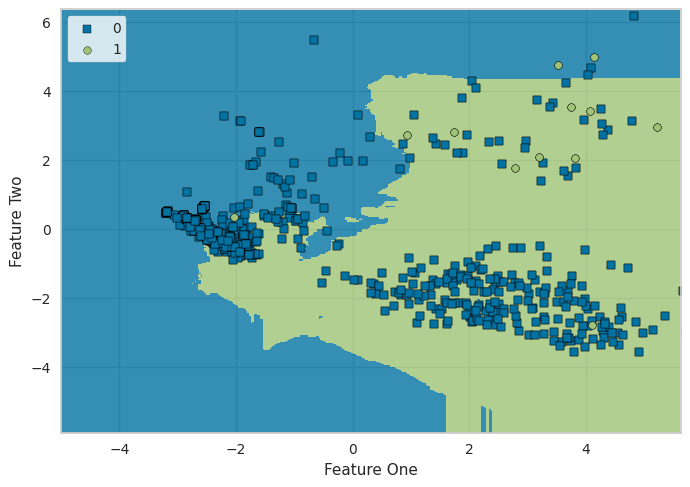

In [0]:
plot_model(best_ensemble_tuned, plot='boundary')

## Explain Best Model

In [0]:
predictions = predict_model(best_ensemble_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.959,0.8935,0.6923,0.2812,0.4,0.3827,0.4248


In [0]:
final_model = finalize_model(best_ensemble_tuned)
save_model(final_model, 'safety_incidents_predictor')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['constrained_stops', 'breakdowns',
                                              'planned_count', 'unplanned_count',
                                              'duration_sum',
                                              'constrained_stops_per_day',
                                              'planned_stops_per_day',
                                              'unplanned_stops_per_day',
                                              'total_defects',
                                              'total_defects_yesterday',
                                              'num_resolved_in_24_hours',
                                              'per_resolved_...
                                     transformer=PowerTransformer(copy=True,
                                                                  method='y

In [0]:
saved_model = load_model('safety_incidents_predictor')
X_pipe = saved_model[:-1].transform(ml_df_class).drop(columns='is_near_miss')
shap_model = saved_model.named_steps['actual_estimator']

Transformation Pipeline and Model Successfully Loaded


In [0]:
# explainer = shap.KernelExplainer(shap_model.predict_proba, shap.kmeans(X_pipe, 10))
# shap_values = explainer.shap_values(X_pipe)
sample_size = min(100, len(X_pipe))  # Use max 100 samples
X_sample = X_pipe.sample(n=sample_size, random_state=42)

# Use fewer background samples
background_size = min(50, len(X_pipe))
background_data = shap.kmeans(X_pipe, background_size)

explainer = shap.KernelExplainer(shap_model.predict_proba, background_data)
shap_values = explainer.shap_values(X_sample)

print(f"Using sample of {sample_size} observations with {background_size} background samples")

  0%|          | 0/100 [00:00<?, ?it/s]

Using sample of 100 observations with 50 background samples


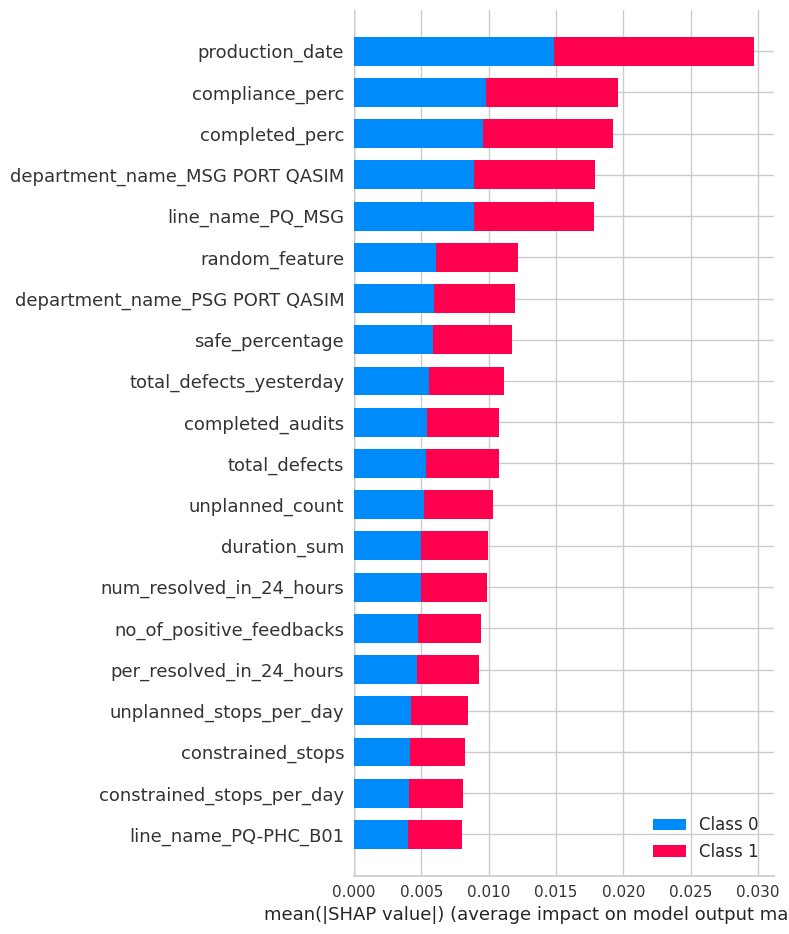

In [0]:
shap.summary_plot(shap_values, X_pipe)

In [0]:
shap.plots.waterfall(explainer(X_pipe.iloc[0]))

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can